## Notebook for evotuning ESM-2

In [2]:
#imports
from datasets import Dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments, EsmForMaskedLM, DataCollatorForLanguageModeling
import torch
import esm
from torch.optim import AdamW
import plotly.express as px
import random
import pandas as pd
from Bio import SeqIO
import numpy as np
import scipy
import math
import datetime

In [3]:
def filt_fas(recdic, acclist, outname):
    fasta = ''
    for rec in list(recdic):
        shrec = rec.split('|')[0]
        if shrec in acclist:
            fasta = fasta + '>%s\n%s\n'%(shrec, str(recdic[rec].seq))
    print(fasta.count('>'))
    with open(outname, 'w') as out:
        out.write(fasta[:-1])

In [4]:
def date_to_decimal_year(date_str):
    
    # Parse the input date string into a datetime object
    if len(date_str.split('-')[1]) == 0:
        dt = datetime.datetime.strptime(date_str, "%Y--")
    elif len(date_str.split('-')[2]) == 0:
        dt = datetime.datetime.strptime(date_str, "%Y-%m-")
    else:
        dt = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    
    # Calculate the decimal year
    decimal_year = dt.year + (dt.month - 1) / 12 + (dt.day - 1) / 365
    
    return decimal_year

<br>

## Sequence download and processing

Download all NCBI flu database complete HA IAV sequences 

Header:
>{accession}|{strain}|{year}-{month}-{day}|{host}|{serotype}|{country}|{taxname}


filter out sequences with ambiguous amino acids and convert to dataframe

In [4]:
headers = [rec.description.split('|') for rec in SeqIO.parse('esm2/ncbiflu_HA_all_110424.fa', 'fasta') if 'X' not in str(rec.seq)]

print(len(headers))

haalldf = pd.DataFrame(headers)
haalldf.columns = ['name', 'strain', 'date', 'host', 'serotype', 'country', 'tax']

seqs = [str(rec.seq) for rec in SeqIO.parse('esm2/ncbiflu_HA_all_110424.fa', 'fasta') if 'X' not in str(rec.seq)]

haalldf['seq'] = seqs

haalldf['lens'] = haalldf['seq'].str.len()

haalldf.to_csv('esm2/ncbiflu_HA_all_110424_noX.csv', index=False)

haalldf

33657


,name,strain,date,host,serotype,country,tax,seq,lens
0,QBM69670,A/China/38888/2012,2012-08-29,Human,H3N2,China,Influenza A virus (A/China/38888/2012),MKTIIALSYILCLVVAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,566
1,AIY59238,A/duck/Shandong/TA01/2012,2012-12-27,Avian,H9N2,China,Influenza A virus (A/duck/Shandong/TA01/2012(H...,METVSLITILLVATVSNADKICIGYQSTNSTETVDTLTENNVPVTH...,560
2,ADE20868,A/Wisconsin/629-S1414/2009,2009-10-26,Human,H1N1,USA,Influenza A virus (A/Wisconsin/629-S1414/2009(...,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566
3,ADK78207,A/rosy-billed pochard/Argentina/CIP051-925/2008,2008-02-,Avian,H6N2,Argentina,Influenza A virus (A/rosy-billed pochard/Argen...,MIAIIVIAILATAGRSDKICIGYHANNSTTQVDTILEKNVTVTHSV...,566
4,ADW80272,A/mallard/Ohio/662/2002,2002-08-19,Avian,"mixed,H6",USA,Influenza A virus (A/mallard/Ohio/662/2002(mix...,MIAIIILAILVSTSKSDRICIGYHANNSTTQVDTILEKNVTVTHSV...,566
...,...,...,...,...,...,...,...,...,...
33652,WJD58476,A/swine/Kansas/A02861449/2023,2023-05-03,Swine,H3N2,USA,Influenza A virus (A/swine/Kansas/A02861449/2023),MKTIIAFSCILCQISSQNLPGSDNSMATLCLGHHAVPNGTLVKTIT...,566
33653,WJN08972,A/California/42/2023,2023-03-06,Human,H3N2,USA,Influenza A virus (A/California/42/2023),MKTIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566
33654,WJN09188,A/Colorado/39/2023,2023-03-21,Human,H3N2,USA,Influenza A virus (A/Colorado/39/2023),MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566
33655,WJN09500,A/Maryland/17/2023,2023-02-06,Human,H3N2,USA,Influenza A virus (A/Maryland/17/2023),MKTIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566


<br>

Convert filtered set to fasta file and perform `mmseqs` clustering below:

In [15]:
filt_fas(SeqIO.to_dict(SeqIO.parse('esm2/ncbiflu_HA_all_110424.fa', 'fasta')), list(haalldf.name), 'esm2/ncbiflu_HA_all_110424_noX.fas')

33657


`mmseqs createdb ncbiflu_HA_all_110424_noX.fas ncbiflu_HA_all_110424_mmseqs/ncbiflu_HA_all_110424_noX`

`cd ncbiflu_HA_all_110424_mmseqs`

`mmseqs cluster ncbiflu_HA_all_110424_noX  ncbiflu_HA_all_110424_noX_clu99 tmp --min-seq-id 0.99 --cov-mode 0`

`mmseqs createtsv ncbiflu_HA_all_110424_noX ncbiflu_HA_all_110424_noX ncbiflu_HA_all_110424_noX_clu99 ncbiflu_HA_all_110424_noX_clu99.tsv`



<br>

Finalise 99% sequence similarity representative sequence set and export:

In [3]:
mmseqdf = pd.read_csv('esm2/ncbiflu_HA_all_110424_mmseqs/ncbiflu_HA_all_110424_noX_clu99.tsv', sep='\t', header=None)

print(len(set(mmseqdf[0])))
mmseqdf

10137


,0,1
0,AID70476,AID70476
1,AIK26366,AIK26366
2,AJJ94035,AJJ94035
3,AJY54598,AJY54598
4,AKH14423,AKH14423
...,...,...
33652,WAK88483,WAK88483
33653,AAA16880,AAA16880
33654,ABE27153,ABE27153
33655,ABW81529,ABW81529


In [4]:
haalldf = pd.read_csv('esm2/ncbiflu_HA_all_110424_noX.csv')

In [ ]:
subsamphadf = haalldf[haalldf.name.isin(set(mmseqdf[0]))]
#also filter out sequences with J characters
subsamphadf = subsamphadf[subsamphadf['seq'].isin([x for x in list(subsamphadf.seq) if 'J' not in x])]
subsamphadf

In [6]:
with open('esm2/ncbiflu_HA_all_110424_mmseqs/ncbiflu_HA_all_110424_noX_clu99.fas', 'w') as outf:
    outf.write('\n'.join(['>%s\n%s'%(n,seq) for n,seq in zip(list(subsamphadf.name), list(subsamphadf.seq))]))

In [7]:
subsamphadf[['name', 'strain', 'date', 'host', 'serotype', 'country']].to_csv('esm2/ncbiflu_HA_all_110424_mmseqs/ncbiflu_HA_all_110424_noX_clu99_meta.csv', index=False)


<br>

## Finetuning datasets

Split clustered dataset by serotype:

In [5]:
haalldf = pd.read_csv('ncbiflu_HA_all_110424_noX.csv')
haalldf

,name,strain,date,host,serotype,country,tax,seq,lens
0,QBM69670,A/China/38888/2012,2012-08-29,Human,H3N2,China,Influenza A virus (A/China/38888/2012),MKTIIALSYILCLVVAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,566
1,AIY59238,A/duck/Shandong/TA01/2012,2012-12-27,Avian,H9N2,China,Influenza A virus (A/duck/Shandong/TA01/2012(H...,METVSLITILLVATVSNADKICIGYQSTNSTETVDTLTENNVPVTH...,560
2,ADE20868,A/Wisconsin/629-S1414/2009,2009-10-26,Human,H1N1,USA,Influenza A virus (A/Wisconsin/629-S1414/2009(...,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566
3,ADK78207,A/rosy-billed pochard/Argentina/CIP051-925/2008,2008-02-,Avian,H6N2,Argentina,Influenza A virus (A/rosy-billed pochard/Argen...,MIAIIVIAILATAGRSDKICIGYHANNSTTQVDTILEKNVTVTHSV...,566
4,ADW80272,A/mallard/Ohio/662/2002,2002-08-19,Avian,"mixed,H6",USA,Influenza A virus (A/mallard/Ohio/662/2002(mix...,MIAIIILAILVSTSKSDRICIGYHANNSTTQVDTILEKNVTVTHSV...,566
...,...,...,...,...,...,...,...,...,...
33652,WJD58476,A/swine/Kansas/A02861449/2023,2023-05-03,Swine,H3N2,USA,Influenza A virus (A/swine/Kansas/A02861449/2023),MKTIIAFSCILCQISSQNLPGSDNSMATLCLGHHAVPNGTLVKTIT...,566
33653,WJN08972,A/California/42/2023,2023-03-06,Human,H3N2,USA,Influenza A virus (A/California/42/2023),MKTIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566
33654,WJN09188,A/Colorado/39/2023,2023-03-21,Human,H3N2,USA,Influenza A virus (A/Colorado/39/2023),MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566
33655,WJN09500,A/Maryland/17/2023,2023-02-06,Human,H3N2,USA,Influenza A virus (A/Maryland/17/2023),MKTIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566


In [7]:
mmseqdf = pd.read_csv('ncbiflu_HA_all_110424_noX_clu99_meta.csv')

print(len(mmseqdf))

haalldf = pd.read_csv('ncbiflu_HA_all_110424_noX.csv')

subsamphadf = haalldf[haalldf.name.isin(set(mmseqdf.name))]
#no ambiguous aa
subsamphadf = subsamphadf[subsamphadf['seq'].isin([x for x in list(subsamphadf.seq) if 'J' not in x])]
# subsamphadf

subsampha_serocl_df = haalldf[haalldf.name.isin(set(mmseqdf.name))]
#no ambiguous aa
subsampha_serocl_df = subsampha_serocl_df[subsampha_serocl_df['seq'].isin([x for x in list(subsampha_serocl_df.seq) if 'J' not in x])]

#no mixed serotypes
subsampha_serocl_df.dropna(subset='serotype', inplace=True)
subsampha_serocl_df = subsampha_serocl_df[subsampha_serocl_df['serotype'].str[0]=='H']

subsampha_serocl_df

10132


,name,strain,date,host,serotype,country,tax,seq,lens
0,QBM69670,A/China/38888/2012,2012-08-29,Human,H3N2,China,Influenza A virus (A/China/38888/2012),MKTIIALSYILCLVVAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,566
1,AIY59238,A/duck/Shandong/TA01/2012,2012-12-27,Avian,H9N2,China,Influenza A virus (A/duck/Shandong/TA01/2012(H...,METVSLITILLVATVSNADKICIGYQSTNSTETVDTLTENNVPVTH...,560
3,ADK78207,A/rosy-billed pochard/Argentina/CIP051-925/2008,2008-02-,Avian,H6N2,Argentina,Influenza A virus (A/rosy-billed pochard/Argen...,MIAIIVIAILATAGRSDKICIGYHANNSTTQVDTILEKNVTVTHSV...,566
5,QFQ20405,A/Sydney/536/2017,2017-08-18,Human,H3N2,Australia,Influenza A virus (A/Sydney/536/2017),MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566
6,ACB32201,A/Guangzhou/483/2006,2006--,Human,H1N1,China,Influenza A virus (A/Guangzhou/483/2006(H1N1)),MKVKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...,565
...,...,...,...,...,...,...,...,...,...
33621,WGL41354,A/swine/Iowa/A02861344/2023,2023-03-28,Swine,H3N2,USA,Influenza A virus (A/swine/Iowa/A02861344/2023),MKTIIVLSQILYLVLAQKLPGNDNNMATLCLGHHAVPNGTMVKTIM...,566
33647,WHU98305,A/environment/Japan/KU-D9/2020,2020-11-23,Environment,H3N2,Japan,Influenza A virus (A/environment/Japan/KU-D9/2...,MKTIIALSYVFCLAFGQDLPGSDNSTATLCLGHHAVPNGTLVKTIT...,566
33648,WIC39748,A/swine/Ohio/A02861391/2023,2023-04-18,Swine,H3N2,USA,Influenza A virus (A/swine/Ohio/A02861391/2023),MKTIIALSYILCLVFAQKIPGNDNGTATLCLGHHAVPNGTIVKTIT...,566
33650,WIL77452,A/swine/Kansas/A02978466/2023,2023-04-07,Swine,H3N2,USA,Influenza A virus (A/swine/Kansas/A02978466/2023),MKTIIALSHILCLVFAQKPHGNDNNMATLCLGHHAVPNGTIVKTIT...,566


**Distribution of sequences per serotype**

In [6]:
subsampha_serocl_df['HAtype'] = [str(x).split('N')[0] for x in list(subsampha_serocl_df.serotype)]
subsampha_serocl_df.HAtype.value_counts()

HAtype
H3          4241
H1          2286
H5           978
H9           907
H6           356
H7           305
H11          157
H2           155
H10          152
H4           150
H12           67
H8            56
H13           40
H16           26
H14            5
H15            4
H17            2
H3,mixed       1
H18            1
H1,mixed       1
Name: count, dtype: int64

### Export the NCBI virus training datasets to fasta files

- H1
- H3
- H5
- H7

In [11]:
for sero in ['H1', 'H3', 'H5', 'H7']:

    thisserodf = subsampha_serocl_df[subsampha_serocl_df.HAtype == sero]
    
    fas = '\n'.join(['>%s\n%s'%(n,s) for n,s in zip(list(thisserodf.name), list(thisserodf.seq))])

    with open('train_data/ncbiflu_HA_all_110424_noX_clu99_filt_%s.fas'%sero, 'w') as out:
        out.write(fas)


fas = '\n'.join(['>%s\n%s'%(n,s) for n,s in zip(list(subsampha_serocl_df.name), list(subsampha_serocl_df.seq))])

with open('train_data/ncbiflu_HA_all_110424_noX_clu99_filt_all.fas', 'w') as out:
    out.write(fas)

<br>
<br>

## Evotuning per serotype

In [12]:
#load base ESM2 model
model_type = "facebook/esm2_t33_650M_UR50D"

In [13]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_type)

In [14]:
def tokenize_function(row): #tokenizer and params including special_tokens_mask required for mlm
    return tokenizer(
        row['seq'],
        padding='max_length',
        truncation=True,
        max_length=566,
        return_special_tokens_mask=True)

In [15]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,return_tensors='pt',mlm_probability=0.15) #provide random masking and return tensors during training per-batch

In [7]:
#clu99 individual serotypes
for sero in ['H7', 'H5', 'H1', 'H3']:

    model = EsmForMaskedLM.from_pretrained(model_type)
    device = torch.device("cuda:0")
    if torch.cuda.is_available():
        model =  model.to(device)
        print("Transferred model to GPU")

    print("\nPreparing models/esm2_t33-%s_110424_clu99_e10_071024"%sero)

    #load protein sequences from fasta file into a list
    seqdat = [str(rec.seq) for rec in SeqIO.parse('train_data/ncbiflu_HA_all_110424_noX_clu99_filt_%s.fas'%sero, 'fasta')]

    #separate 80-20 training-validation dataset
    valseqs = random.sample(seqdat, round(0.2*len(seqdat))) 
    trainseqs = list(set(seqdat) - set(valseqs))
    
    tempdf = pd.DataFrame({'seq':trainseqs})
    templ = tempdf.seq.tolist()
    templ
    train_dataset = Dataset.from_pandas(tempdf[['seq']])
    print(train_dataset)
    
    tempdf = pd.DataFrame({'seq':valseqs})
    tempdf
    templ = tempdf.seq.tolist()
    templ
    val_dataset = Dataset.from_pandas(tempdf[['seq']])
    print(val_dataset)

    #apply the tokenizer to the dataset
    train_dataset = train_dataset.map( 
        tokenize_function,
        batched=True,
        num_proc=4,
        remove_columns=train_dataset.column_names,
    )
    
    val_dataset = val_dataset.map(
        tokenize_function,
        batched=True,
        num_proc=4,
        remove_columns=val_dataset.column_names,
    )
    
    training_args = TrainingArguments(
        output_dir="/data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-%s_110424_clu99_e10_071024"%sero,
        overwrite_output_dir=True,
        num_train_epochs = 10,
        # logging_steps=100,
        logging_strategy='epoch',
        save_strategy='epoch',
        per_device_train_batch_size=4,
        per_device_eval_batch_size=8,
        evaluation_strategy="epoch",
        save_total_limit=5,
        seed=13,
    #     fp16=True,
        dataloader_num_workers=4,
        disable_tqdm=False
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        #tokenizer=tokenizer, 
    )
    
    train_result = trainer.train()
    # trainer.save_model("/data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-%s_110424_clu99_e10_071024"%sero)

    metrics = train_result.metrics
    
    # save train results
    trainer.log_metrics("/data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-%s_110424_clu99_e10_071024_metrics"%sero, metrics)
    trainer.save_metrics("/data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-%s_110424_clu99_e10_071024_metrics"%sero, metrics)
    with open("/data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-%s_110424_clu99_e10_071024.log"%sero, 'w') as out:
        out.write(str(trainer.state.log_history))



Transferred model to GPU

Preparing models/esm2_t33-H7_110424_clu99_e10_071024
Dataset({
    features: ['seq'],
    num_rows: 244
})
Dataset({
    features: ['seq'],
    num_rows: 61
})


Map (num_proc=4):   0%|          | 0/244 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/61 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.570000,0.256900
2,0.254300,0.188442
3,0.176400,0.170961
4,0.156300,0.136310
5,0.140100,0.135929
6,0.130200,0.130320
7,0.125000,0.135819
8,0.116100,0.111578
9,0.112700,0.116792
10,0.113800,0.115878


***** /data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-H7_110424_clu99_e10_071024_metrics metrics *****
  epoch                    =       10.0
  total_flos               =  5023880GF
  train_loss               =     0.1895
  train_runtime            = 0:03:47.63
  train_samples_per_second =     10.719
  train_steps_per_second   =      0.703
Transferred model to GPU

Preparing models/esm2_t33-H5_110424_clu99_e10_071024
Dataset({
    features: ['seq'],
    num_rows: 782
})
Dataset({
    features: ['seq'],
    num_rows: 196
})


Map (num_proc=4):   0%|          | 0/782 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/196 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.281300,0.180899
2,0.163000,0.147590
3,0.143400,0.148471
4,0.132600,0.131849
5,0.124700,0.123996
6,0.117200,0.122398
7,0.112500,0.113916
8,0.103300,0.108079
9,0.101900,0.098929
10,0.099300,0.105676


***** /data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-H5_110424_clu99_e10_071024_metrics metrics *****
  epoch                    =       10.0
  total_flos               = 16101125GF
  train_loss               =     0.1379
  train_runtime            = 0:09:22.53
  train_samples_per_second =     13.901
  train_steps_per_second   =      0.871
Transferred model to GPU

Preparing models/esm2_t33-H1_110424_clu99_e10_071024
Dataset({
    features: ['seq'],
    num_rows: 1829
})
Dataset({
    features: ['seq'],
    num_rows: 457
})


Map (num_proc=4):   0%|          | 0/1829 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/457 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.240100,0.159010
2,0.153300,0.136296
3,0.132400,0.124757
4,0.119800,0.112384
5,0.111500,0.106060
6,0.106300,0.100868
7,0.102800,0.101567
8,0.096400,0.096892
9,0.095400,0.096164
10,0.091300,0.094790


***** /data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-H1_110424_clu99_e10_071024_metrics metrics *****
  epoch                    =       10.0
  total_flos               = 37658514GF
  train_loss               =     0.1249
  train_runtime            = 0:20:28.49
  train_samples_per_second =     14.888
  train_steps_per_second   =      0.936
Transferred model to GPU

Preparing models/esm2_t33-H3_110424_clu99_e10_071024
Dataset({
    features: ['seq'],
    num_rows: 3393
})
Dataset({
    features: ['seq'],
    num_rows: 848
})


Map (num_proc=4):   0%|          | 0/3393 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/848 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.183300,0.130165
2,0.111100,0.109694
3,0.098600,0.095662
4,0.091300,0.090847
5,0.082600,0.084576
6,0.080900,0.086781
7,0.076900,0.076733
8,0.074600,0.079646
9,0.071200,0.080124
10,0.068000,0.073041


***** /data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-H3_110424_clu99_e10_071024_metrics metrics *****
  epoch                    =       10.0
  total_flos               = 69860764GF
  train_loss               =     0.0939
  train_runtime            = 0:36:45.91
  train_samples_per_second =     15.381
  train_steps_per_second   =      0.966


### Best checkpoint out of the 10 epochs run for each training dataset (serotype), based on the training loss:

- H7 : 8
- H5 : 9
- H1 : 10
- H3 : 10

<br>

## HA-80 data split

Split dataset into the earliest 80% and latest 20% of the sequence sampling distribution:

In [17]:
subsamphadf_dats = subsamphadf[~subsamphadf.date.isin(['--', 'unknown--', 'NON--', 'Unknown--'])]
#manually correct Brescia date (https://www.jstor.org/stable/3298866):
subsamphadf_dats.loc[23719, 'date'] = '1935--'
print(subsamphadf_dats.loc[23719])
subsamphadf_dats['num_year'] = [date_to_decimal_year(x) for x in list(subsamphadf_dats.date)]
subsamphadf_dats

name                                                 ACZ36872
strain                                 A/chicken/Brescia/1902
date                                                   1935--
host                                                    Avian
serotype                                                 H7N7
country                                                 Italy
tax          Influenza A virus (A/chicken/Brescia/1902(H7N7))
seq         MNTQILVFALVAVIHTNADKICLGHHAVSNGTKVNTLTERGVEVVN...
lens                                                      563
Name: 23719, dtype: object


,name,strain,date,host,serotype,country,tax,seq,lens,num_year
0,QBM69670,A/China/38888/2012,2012-08-29,Human,H3N2,China,Influenza A virus (A/China/38888/2012),MKTIIALSYILCLVVAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,566,2012.660046
1,AIY59238,A/duck/Shandong/TA01/2012,2012-12-27,Avian,H9N2,China,Influenza A virus (A/duck/Shandong/TA01/2012(H...,METVSLITILLVATVSNADKICIGYQSTNSTETVDTLTENNVPVTH...,560,2012.987900
3,ADK78207,A/rosy-billed pochard/Argentina/CIP051-925/2008,2008-02-,Avian,H6N2,Argentina,Influenza A virus (A/rosy-billed pochard/Argen...,MIAIIVIAILATAGRSDKICIGYHANNSTTQVDTILEKNVTVTHSV...,566,2008.083333
5,QFQ20405,A/Sydney/536/2017,2017-08-18,Human,H3N2,Australia,Influenza A virus (A/Sydney/536/2017),MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566,2017.629909
6,ACB32201,A/Guangzhou/483/2006,2006--,Human,H1N1,China,Influenza A virus (A/Guangzhou/483/2006(H1N1)),MKVKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...,565,2006.000000
...,...,...,...,...,...,...,...,...,...,...
33621,WGL41354,A/swine/Iowa/A02861344/2023,2023-03-28,Swine,H3N2,USA,Influenza A virus (A/swine/Iowa/A02861344/2023),MKTIIVLSQILYLVLAQKLPGNDNNMATLCLGHHAVPNGTMVKTIM...,566,2023.240639
33647,WHU98305,A/environment/Japan/KU-D9/2020,2020-11-23,Environment,H3N2,Japan,Influenza A virus (A/environment/Japan/KU-D9/2...,MKTIIALSYVFCLAFGQDLPGSDNSTATLCLGHHAVPNGTLVKTIT...,566,2020.893607
33648,WIC39748,A/swine/Ohio/A02861391/2023,2023-04-18,Swine,H3N2,USA,Influenza A virus (A/swine/Ohio/A02861391/2023),MKTIIALSYILCLVFAQKIPGNDNGTATLCLGHHAVPNGTIVKTIT...,566,2023.296575
33650,WIL77452,A/swine/Kansas/A02978466/2023,2023-04-07,Swine,H3N2,USA,Influenza A virus (A/swine/Kansas/A02978466/2023),MKTIIALSHILCLVFAQKPHGNDNNMATLCLGHHAVPNGTIVKTIT...,566,2023.266438


In [18]:
subsamphadf_dats.sort_values(by='num_year')

,name,strain,date,host,serotype,country,tax,seq,lens,num_year
15065,AAD17229,A/South Carolina/1/1918,1918--,Human,H1N1,USA,Influenza A virus (A/South Carolina/1/1918(H1N1)),MEARLLVLLCAFAATNADTICIGYHANNSTDTVDTVLEKNVTVTHS...,566,1918.000000
1860,CAA78263,A/fowl/Dutch/27,1927--,Avian,H7N7,Netherlands,Influenza A virus (A/fowl/Dutch/27(H7N7)),MNTQILVFALVAVIHTNADKICLGHHAVSNGTKVNTLTERGVEVVN...,563,1927.000000
1994,ABV25634,A/swine/Iowa/15/1930,1930--,Swine,H1N1,USA,Influenza A virus (A/swine/Iowa/15/1930(H1N1)),MKAILLVLLCAFAATNADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566,1930.000000
30501,ACV52112,A/swine/USA/1976-MA/1931,1931--,Swine,H1N1,USA,Influenza A virus (A/swine/USA/1976-MA/1931(H1...,MKARLLVLLCAFAATNADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566,1931.000000
3744,AAA92280,A/WS/1933,1933--,Human,H1N1,Australia,Influenza A virus (A/WS/1933(H1N1)),MKAKLLVLLCALAATDADTICIGYHANNSTDTVDTLLEKNVTVTHS...,566,1933.000000
...,...,...,...,...,...,...,...,...,...,...
15026,WIC39776,A/swine/Nebraska/A02861435/2023,2023-04-25,Swine,H3N2,USA,Influenza A virus (A/swine/Nebraska/A02861435/...,MRTIIVLSQILYLVFAQKLPGNDNNMATLCLGHHAVPNGTIVKTIT...,566,2023.315753
29989,WIM36327,A/swine/Kansas/A02978480/2023,2023-05-01,Swine,H3N2,USA,Influenza A virus (A/swine/Kansas/A02978480/2023),MKTIIALSHILCLVFAQKLHGNDNNMATLCLGHHAVPNGTIVKTIT...,566,2023.333333
3730,WIM36335,A/swine/Minnesota/A02978501/2023,2023-05-02,Swine,H3N2,USA,Influenza A virus (A/swine/Minnesota/A02978501...,MKTIIAFSCILCLVIAQKLPGSDNSMATLCLGHHAVPNGTLVKTIT...,566,2023.336073
33652,WJD58476,A/swine/Kansas/A02861449/2023,2023-05-03,Swine,H3N2,USA,Influenza A virus (A/swine/Kansas/A02861449/2023),MKTIIAFSCILCQISSQNLPGSDNSMATLCLGHHAVPNGTLVKTIT...,566,2023.338813


In [19]:
subsamphadf_dats.num_year.describe()

count    10126.000000
mean      2008.858205
std         10.434041
min       1918.000000
25%       2006.586758
50%       2011.083333
75%       2014.755479
max       2023.338813
Name: num_year, dtype: float64

<br>

*80th quantile date and plot:*

In [20]:
subsamphadf_dats.num_year.quantile(0.8)

2015.169406392694

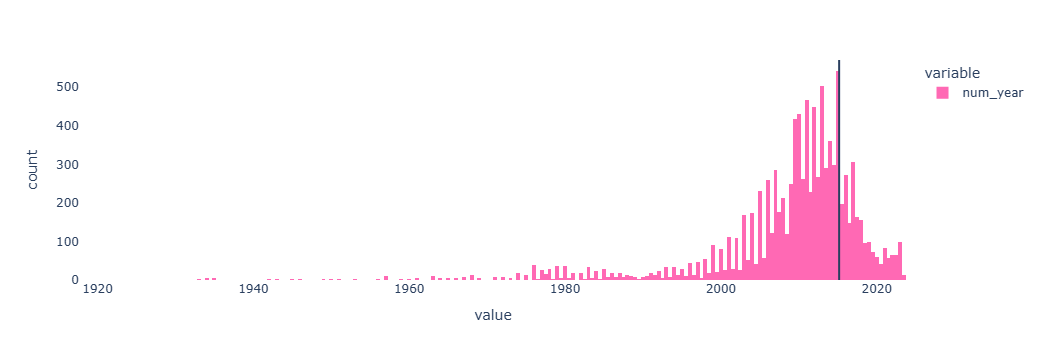

In [33]:
datsplit_fig = px.histogram(subsamphadf_dats.num_year, nbins=300,  color_discrete_sequence=['hotpink'] )
datsplit_fig.add_vline(x=2015.169406392694)
datsplit_fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',  # Transparent plot background
    'paper_bgcolor': 'rgba(0, 0, 0, 0)'  # Transparent paper background
})
datsplit_fig.show()

<br>

Split sequence set and export:

In [9]:
subsamphadf_dats_premed = subsamphadf_dats[subsamphadf_dats.num_year < 2015.169406392694]
subsamphadf_dats_premed.sort_values(by='num_year')

,name,strain,date,host,serotype,country,tax,seq,lens,num_year
23719,ACZ36872,A/chicken/Brescia/1902,1902--,Avian,H7N7,Italy,Influenza A virus (A/chicken/Brescia/1902(H7N7)),MNTQILVFALVAVIHTNADKICLGHHAVSNGTKVNTLTERGVEVVN...,563,1902.000000
15065,AAD17229,A/South Carolina/1/1918,1918--,Human,H1N1,USA,Influenza A virus (A/South Carolina/1/1918(H1N1)),MEARLLVLLCAFAATNADTICIGYHANNSTDTVDTVLEKNVTVTHS...,566,1918.000000
1860,CAA78263,A/fowl/Dutch/27,1927--,Avian,H7N7,Netherlands,Influenza A virus (A/fowl/Dutch/27(H7N7)),MNTQILVFALVAVIHTNADKICLGHHAVSNGTKVNTLTERGVEVVN...,563,1927.000000
1994,ABV25634,A/swine/Iowa/15/1930,1930--,Swine,H1N1,USA,Influenza A virus (A/swine/Iowa/15/1930(H1N1)),MKAILLVLLCAFAATNADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566,1930.000000
30501,ACV52112,A/swine/USA/1976-MA/1931,1931--,Swine,H1N1,USA,Influenza A virus (A/swine/USA/1976-MA/1931(H1...,MKARLLVLLCAFAATNADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566,1931.000000
...,...,...,...,...,...,...,...,...,...,...
32344,AKD00849,A/swine/Minnesota/A01489546/2015,2015-02-26,Swine,H1N1,USA,Influenza A virus (A/swine/Minnesota/A01489546...,MKAVLVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566,2015.151826
20091,ALN39740,A/New York/4811/2015,2015-02-26,Human,H3N2,USA,Influenza A virus (A/New York/4811/2015(H3N2)),MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,566,2015.151826
27336,AKD00646,A/swine/North Carolina/A01555658/2015,2015-02-26,Swine,H1N1,USA,Influenza A virus (A/swine/North Carolina/A015...,MKAILVVLLYAFTTASADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566,2015.151826
27344,AKE37400,A/swine/Indiana/A01260829/2015,2015-02-26,Swine,H1N1,USA,Influenza A virus (A/swine/Indiana/A01260829/2...,MQAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566,2015.151826


In [10]:

fas = '\n'.join(['>%s\n%s'%(n,s) for n,s in zip(list(subsamphadf_dats_premed.name), list(subsamphadf_dats_premed.seq))])

with open('train_data/ncbiflu_HA_all_110424_noX_clu99_filt_datesplit8020.fas', 'w') as out:
    out.write(fas)

<br>

### Train base ESM2 model using HA-80 dataset as above:

In [16]:
model = EsmForMaskedLM.from_pretrained(model_type)
device = torch.device("cuda:0")
if torch.cuda.is_available():
    model =  model.to(device)
    print("Transferred model to GPU")

#load protein sequences from fasta file into a list
seqdat = [str(rec.seq) for rec in SeqIO.parse('train_data/ncbiflu_HA_all_110424_noX_clu99_filt_datesplit8020.fas', 'fasta')]

#separate 80-20 training-validation dataset
valseqs = random.sample(seqdat, round(0.2*len(seqdat))) 
trainseqs = list(set(seqdat) - set(valseqs))

tempdf = pd.DataFrame({'seq':trainseqs})
templ = tempdf.seq.tolist()
templ
train_dataset = Dataset.from_pandas(tempdf[['seq']])
print(train_dataset)

tempdf = pd.DataFrame({'seq':valseqs})
tempdf
templ = tempdf.seq.tolist()
templ
val_dataset = Dataset.from_pandas(tempdf[['seq']])
print(val_dataset)

#apply the tokenizer to the dataset
train_dataset = train_dataset.map( 
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=train_dataset.column_names,
)

val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=val_dataset.column_names,
)

training_args = TrainingArguments(
    output_dir="/media/spyros/HD-ADU3/spyros/flu_LLM_evol_data/ncbiflu_models_datesplit241024/esm2_t33-HA_all_110424_datesplit8020_e10_241024",
    overwrite_output_dir=True,
    num_train_epochs = 10,
    # logging_steps=100,
    logging_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_total_limit=5,
    seed=13,
#     fp16=True,
    dataloader_num_workers=4,
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    #tokenizer=tokenizer, 
)

train_result = trainer.train()
# trainer.save_model("/data2/spyros/flu_LLM_evol_data/ncbiflu_models_071024/esm2_t33-%s_110424_clu99_e10_071024"%sero)

metrics = train_result.metrics

# save train results
trainer.log_metrics("/media/spyros/HD-ADU3/spyros/flu_LLM_evol_data/ncbiflu_models_datesplit241024/esm2_t33-HA_all_110424_datesplit8020_e10_241024_metrics", metrics)
trainer.save_metrics("/media/spyros/HD-ADU3/spyros/flu_LLM_evol_data/ncbiflu_models_datesplit241024/esm2_t33-HA_all_110424_datesplit8020_e10_241024_metrics", metrics)
with open("/media/spyros/HD-ADU3/spyros/flu_LLM_evol_data/ncbiflu_models_datesplit241024/esm2_t33-HA_all_110424_datesplit8020_e10_241024.log", 'w') as out:
    out.write(str(trainer.state.log_history))

Transferred model to GPU
Dataset({
    features: ['seq'],
    num_rows: 6479
})
Dataset({
    features: ['seq'],
    num_rows: 1620
})


Map (num_proc=4):   0%|          | 0/6479 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1620 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.301300,0.186084
2,0.156000,0.141016
3,0.132500,0.127148
4,0.118200,0.114368
5,0.108000,0.111863
6,0.102700,0.104122
7,0.095400,0.099223
8,0.092500,0.098480
9,0.087700,0.095319
10,0.084700,0.090609


***** /media/spyros/HD-ADU3/spyros/flu_LLM_evol_data/ncbiflu_models_datesplit241024/esm2_t33-HA_all_110424_datesplit8020_e10_241024_metrics metrics *****
  epoch                    =        10.0
  total_flos               = 133400499GF
  train_loss               =      0.1279
  train_runtime            =  1:14:20.45
  train_samples_per_second =      14.525
  train_steps_per_second   =       0.908


<br>
<br>

## HA-all

Finally train the base ESM2 model on all serotypes as above 

In [19]:
model_type = "facebook/esm2_t33_650M_UR50D"

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_type)

model = EsmForMaskedLM.from_pretrained(model_type)

In [21]:
def tokenize_function(row): #tokenizer and params including special_tokens_mask required for mlm
    return tokenizer(
        row['seq'],
        padding='max_length',
        truncation=True,
        max_length=566,
        return_special_tokens_mask=True)

In [22]:
device = torch.device("cuda:0")
if torch.cuda.is_available():
    model =  model.to(device)
    print("Transferred model to GPU")

Transferred model to GPU


In [11]:
haallseqs = list(subsamphadf.seq)

seqdat = haallseqs

valseqs = random.sample(seqdat, round(0.2*len(seqdat))) 
trainseqs = list(set(seqdat) - set(valseqs))
# trainseqs = random.sample(seqdat, round(0.008*len(seqdat)))

tempdf = pd.DataFrame({'seq':trainseqs})
tempdf

templ = tempdf.seq.tolist()
templ
train_dataset = Dataset.from_pandas(tempdf[['seq']])
print(train_dataset)


tempdf = pd.DataFrame({'seq':valseqs})
tempdf

templ = tempdf.seq.tolist()
templ
val_dataset = Dataset.from_pandas(tempdf[['seq']])
print(val_dataset)

train_dataset = train_dataset.map( #apply the tokenizer to the dataset
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=train_dataset.column_names,
)

val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=val_dataset.column_names,
)

Dataset({
    features: ['seq'],
    num_rows: 8106
})
Dataset({
    features: ['seq'],
    num_rows: 2026
})


Map (num_proc=4):   0%|          | 0/8106 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2026 [00:00<?, ? examples/s]

In [12]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,return_tensors='pt',mlm_probability=0.15) #provide random masking and return tensors during training per-batch

In [13]:
training_args = TrainingArguments(
    output_dir="models",
    overwrite_output_dir=True,
    num_train_epochs = 10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_total_limit=2,
    seed=13,
#     fp16=True,
    dataloader_num_workers=4,
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    #tokenizer=tokenizer, 
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.157600,0.154004
2,0.126500,0.125204
3,0.112500,0.113177
4,0.104200,0.102742
5,0.093100,0.097490
6,0.089500,0.091278
7,0.081800,0.089089
8,0.079300,0.084486
9,0.073600,0.081549
10,0.071500,0.078962


TrainOutput(global_step=20270, training_loss=0.1105185261723086, metrics={'train_runtime': 18358.2226, 'train_samples_per_second': 4.415, 'train_steps_per_second': 1.104, 'total_flos': 1.792074028936766e+17, 'train_loss': 0.1105185261723086, 'epoch': 10.0})

In [15]:
trainer.save_model("models/esm2_t33-HA_all_110424_clu99_e10")

<br>
<br>
<br>

### protT5MLM

The training sequence datasets created above can be used for evotuning protT5MLM using the provided `evotune_T5EncoderMLM.py` script.